# Import packages

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 500)
from scipy.stats import levy_stable

from datetime import datetime
from scipy.stats import kstest
from scipy.stats import jarque_bera
# from arch.unitroot import ADF
from scipy.stats import kurtosis
from scipy.stats import skew
# from arch import arch_model

import pickle

import ta

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import webbrowser

plt.style.use('classic')
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 300)

# %config inlinebackend.figure_format = 'svg'

In [2]:
import sys

sys.path.insert(0, 'D:/Intraday_trading')

In [3]:
from src.support import *

# Import and pre-processing data

## Interval data

In [4]:
%%time

interval_data = pd.read_pickle('D:/Intraday_trading/Training/Data/XAUUSD_M15_1.pkl')

interval_data = interval_data.set_index('DATE_TIME')
interval_data.index = pd.to_datetime(interval_data.index)

interval_data['DATE'] = pd.to_datetime(interval_data['DATE'])
interval_data['OPEN'] = interval_data['OPEN']
interval_data['HIGH'] = interval_data['HIGH']
interval_data['LOW'] = interval_data['LOW']
interval_data['CLOSE'] = interval_data['CLOSE']


CPU times: total: 31.2 ms
Wall time: 23.5 ms


### Prepare_df

In [5]:
df_4_hour = prepare_df(df = interval_data, timeframe = '4H')
df_1_day = prepare_df(df = interval_data, timeframe = '1D')
df_15_min = prepare_df(df = interval_data, timeframe = '15min')


In [6]:
df_15_min.shape, df_4_hour.shape, df_1_day.shape, 

((99741, 31), (6783, 31), (1311, 31))

In [7]:
# plot_df(df_1_day, 
#         path = None,# 'D:/Intraday_trading/Training/Saved_results/plot_df.html', 
#         open_tab = False)

# Basic stats check

* Distributions of number up/ down candles
* Distributions of values change of a candle (Open-Close, High-Low)
* Number of candles during an up/ down trend

In [8]:
df_1_day['WHOLE_RANGE'] = df_1_day['HIGH'] - df_1_day['LOW']
df_4_hour['WHOLE_RANGE'] = df_4_hour['HIGH'] - df_4_hour['LOW']
df_15_min['WHOLE_RANGE'] = df_15_min['HIGH'] - df_15_min['LOW']

df_1_day['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day['WHOLE_RANGE'], 10)
df_4_hour['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour['WHOLE_RANGE'], 10)
df_15_min['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min['WHOLE_RANGE'], 10)

df_1_day['GRP_BODY'] = pd.qcut(df_1_day['BODY'], 10)
df_4_hour['GRP_BODY'] = pd.qcut(df_4_hour['BODY'], 10)
df_15_min['GRP_BODY'] = pd.qcut(df_15_min['BODY'], 10)

df_1_day['YEAR'] = df_1_day.index.strftime('%Y')
df_1_day['WEEK'] = df_1_day.index.strftime('%Y%W')
df_1_day['MONTH'] = df_1_day.index.strftime('%Y%m')

df_4_hour['YEAR'] = df_4_hour.index.strftime('%Y')
df_4_hour['WEEK'] = df_4_hour.index.strftime('%Y%W')
df_4_hour['MONTH'] = df_4_hour.index.strftime('%Y%m')

df_15_min['YEAR'] = df_15_min.index.strftime('%Y')
df_15_min['WEEK'] = df_15_min.index.strftime('%Y%W')
df_15_min['MONTH'] = df_15_min.index.strftime('%Y%m')


## Daily stats (look by year, month)

### Number of up/ down candles

* Number of up and down candles are relatively equal in 2021, 2022, 2023;
* In 2024, number of up is 30 more than number of down
* Up to 2025/3/21, up is 44, down is 25 (20 days different)

In [9]:
df_1_day.index[0], df_1_day.index[-1] 

(Timestamp('2021-01-03 00:00:00'), Timestamp('2025-03-21 00:00:00'))

In [21]:
df_temp = pd.pivot_table(
    df_1_day, 
    index = 'YEAR',
    columns = 'FLAG_INCREASE_CANDLE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
).reset_index()

df_temp[0] = df_temp[0]/df_temp['All']
df_temp[1] = df_temp[1]/df_temp['All']

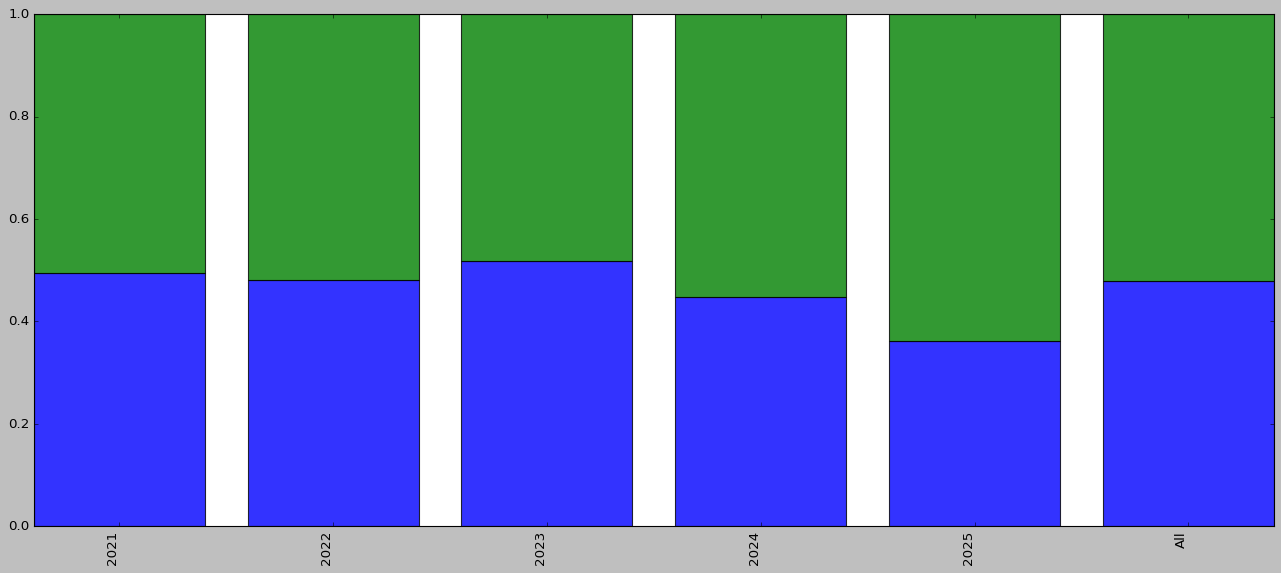

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,8))

ax.bar(df_temp['YEAR'], df_temp[0], alpha = 0.8)
ax.bar(df_temp['YEAR'], df_temp[1], bottom = df_temp[0], alpha = 0.8)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

In [ ]:
df_temp = pd.pivot_table(
    df_1_day, 
    index = ['MONTH'],
    columns = 'FLAG_INCREASE_CANDLE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
).reset_index()

df_temp[0] = df_temp[0]/df_temp['All']
df_temp[1] = df_temp[1]/df_temp['All']

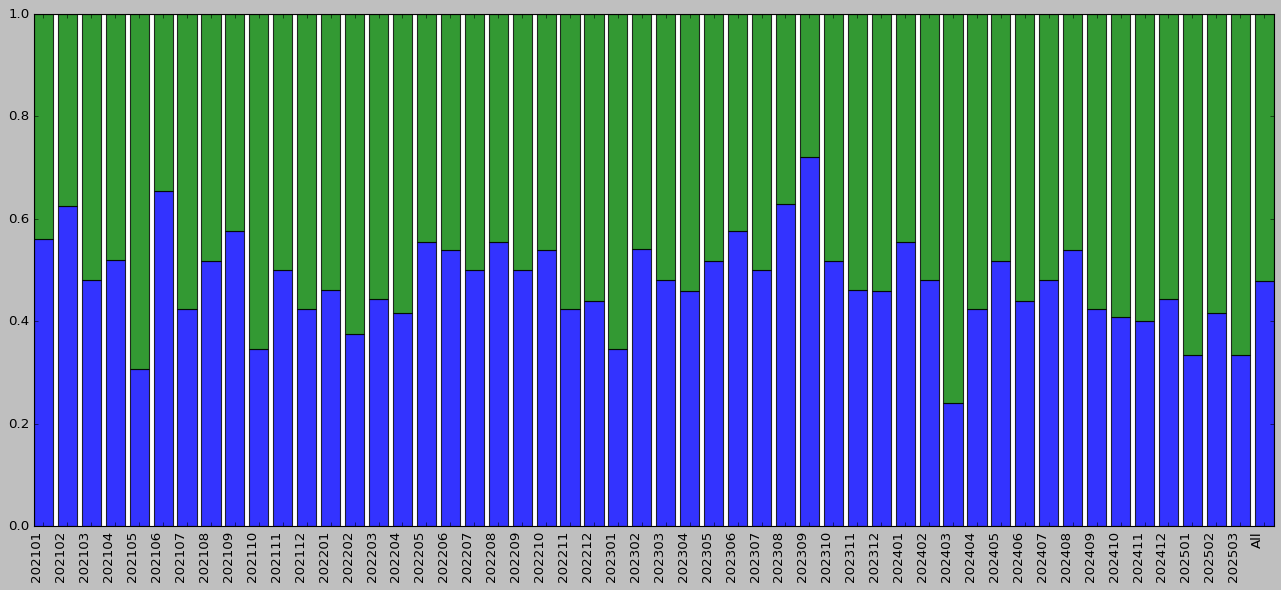

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,8))

ax.bar(df_temp['MONTH'], df_temp[0], alpha = 0.8)
ax.bar(df_temp['MONTH'], df_temp[1], bottom = df_temp[0], alpha = 0.8)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

### Values of candles

* For body of candles, only 40% (~50% in 2024, 2025) of days with the values of body > 10, with the number of up/ down candles is almost balanced, more biased up candle; 2024, 2025 more up candles
* For whole range of candles, ~80% of days with the values of whole range > 12, more biased up candle

Whole range prediction will have more values, trading opportunities (Shadow prediction, PO3, ...)



#### Body

In [70]:
df_temp = pd.pivot_table(
    df_1_day, 
    index = ['YEAR'],
    columns = 'GRP_BODY',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)

In [71]:
df_temp

GRP_BODY,"(0.0, 1.065]","(1.065, 2.096]","(2.096, 3.613]","(3.613, 5.492]","(5.492, 7.733]","(7.733, 10.735]","(10.735, 14.158]","(14.158, 19.47]","(19.47, 27.872]","(27.872, 109.258]",All
YEAR,,,,,,,,,,,
2021,0.106452,0.106452,0.096774,0.148387,0.106452,0.116129,0.093548,0.083871,0.083871,0.058065,1.0
2022,0.090323,0.087097,0.106452,0.093548,0.125806,0.096774,0.112903,0.103226,0.100000,0.083871,1.0
2023,0.126214,0.119741,0.110032,0.093851,0.087379,0.110032,0.106796,0.097087,0.084142,0.064725,1.0
2024,0.089457,0.092652,0.089457,0.073482,0.076677,0.092652,0.089457,0.111821,0.111821,0.172524,1.0
2025,0.057971,0.072464,0.086957,0.057971,0.115942,0.028986,0.086957,0.115942,0.188406,0.188406,1.0
All,0.100686,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,1.0


#### Body intersect with up/ down candles

In [72]:
df_temp = pd.pivot_table(
    df_1_day, 
    index = ['YEAR', 'FLAG_INCREASE_CANDLE'],
    columns = 'GRP_BODY',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)

In [73]:
df_temp

GRP_BODY                   (0.0, 1.065]  (1.065, 2.096]  (2.096, 3.613]  \
YEAR FLAG_INCREASE_CANDLE                                                 
2021 0                         0.117647        0.124183        0.091503   
     1                         0.095541        0.089172        0.101911   
2022 0                         0.060403        0.060403        0.134228   
     1                         0.118012        0.111801        0.080745   
2023 0                         0.150000        0.143750        0.087500   
     1                         0.100671        0.093960        0.134228   
2024 0                         0.128571        0.078571        0.107143   
     1                         0.057803        0.104046        0.075145   
2025 0                         0.080000        0.040000        0.120000   
     1                         0.045455        0.090909        0.068182   
All                            0.100686        0.099924        0.099924   

GRP_BODY                   (3.613, 5.492]  (5.492, 7.733]  (7.733, 10.735]  \
YEAR FLAG_INCREASE_CANDLE                                                    
2021 0                           0.124183        0.104575         0.137255   
     1                           0.171975        0.108280         0.095541   
2022 0                           0.100671        0.127517         0.087248   
     1                           0.086957        0.124224         0.105590   
2023 0                           0.100000        0.087500         0.131250   
     1                           0.087248        0.087248         0.087248   
2024 0                           0.092857        0.064286         0.064286   
     1                           0.057803        0.086705         0.115607   
2025 0                           0.080000        0.120000         0.040000   
     1                           0.045455        0.113636         0.022727   
All                              0.099924        0.099924         0.099924   

GRP_BODY                   (10.735, 14.158]  (14.158, 19.47]  (19.47, 27.872]  \
YEAR FLAG_INCREASE_CANDLE                                                       
2021 0                             0.071895         0.084967         0.058824   
     1                             0.114650         0.082803         0.108280   
2022 0                             0.120805         0.114094         0.107383   
     1                             0.105590         0.093168         0.093168   
2023 0                             0.087500         0.100000         0.062500   
     1                             0.127517         0.093960         0.107383   
2024 0                             0.064286         0.135714         0.128571   
     1                             0.109827         0.092486         0.098266   
2025 0                             0.080000         0.160000         0.120000   
     1                             0.090909         0.090909         0.227273   
All                                0.099924         0.099924         0.099924   

GRP_BODY                   (27.872, 109.258]  All  
YEAR FLAG_INCREASE_CANDLE                          
2021 0                              0.084967  1.0  
     1                              0.031847  1.0  
2022 0                              0.087248  1.0  
     1                              0.080745  1.0  
2023 0                              0.050000  1.0  
     1                              0.080537  1.0  
2024 0                              0.135714  1.0  
     1                              0.202312  1.0  
2025 0                              0.160000  1.0  
     1                              0.204545  1.0  
All                                 0.099924  1.0

#### Whole range

In [74]:
df_temp = pd.pivot_table(
    df_1_day, 
    index = ['YEAR'],
    columns = 'GRP_WHOLE_RANGE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)

display(df_temp)


GRP_WHOLE_RANGE,"(1.5350000000000001, 4.536]","(4.536, 12.127]","(12.127, 15.683]","(15.683, 18.562]","(18.562, 21.243]","(21.243, 24.835]","(24.835, 28.63]","(28.63, 33.542]","(33.542, 41.231]","(41.231, 115.024]",All
YEAR,,,,,,,,,,,
2021,0.112903,0.112903,0.122581,0.132258,0.119355,0.096774,0.100000,0.070968,0.087097,0.045161,1.0
2022,0.100000,0.090323,0.116129,0.096774,0.122581,0.132258,0.090323,0.090323,0.083871,0.077419,1.0
2023,0.116505,0.110032,0.129450,0.126214,0.113269,0.100324,0.084142,0.100324,0.061489,0.058252,1.0
2024,0.079872,0.095847,0.047923,0.060703,0.057508,0.079872,0.124601,0.134185,0.130990,0.188498,1.0
2025,0.072464,0.057971,0.028986,0.028986,0.043478,0.057971,0.101449,0.115942,0.260870,0.231884,1.0
All,0.100686,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,0.099924,1.0


#### Whole range intersect with up/ down candles

In [75]:


df_temp = pd.pivot_table(
    df_1_day, 
    index = ['YEAR', 'FLAG_INCREASE_CANDLE'],
    columns = 'GRP_WHOLE_RANGE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)

display(df_temp)

GRP_WHOLE_RANGE            (1.5350000000000001, 4.536]  (4.536, 12.127]  \
YEAR FLAG_INCREASE_CANDLE                                                 
2021 0                                        0.130719         0.117647   
     1                                        0.095541         0.108280   
2022 0                                        0.100671         0.080537   
     1                                        0.099379         0.099379   
2023 0                                        0.125000         0.106250   
     1                                        0.107383         0.114094   
2024 0                                        0.092857         0.092857   
     1                                        0.069364         0.098266   
2025 0                                        0.080000         0.040000   
     1                                        0.068182         0.068182   
All                                           0.100686         0.099924   

GRP_WHOLE_RANGE            (12.127, 15.683]  (15.683, 18.562]  \
YEAR FLAG_INCREASE_CANDLE                                       
2021 0                             0.117647          0.111111   
     1                             0.127389          0.152866   
2022 0                             0.093960          0.080537   
     1                             0.136646          0.111801   
2023 0                             0.162500          0.150000   
     1                             0.093960          0.100671   
2024 0                             0.042857          0.064286   
     1                             0.052023          0.057803   
2025 0                             0.080000          0.040000   
     1                             0.000000          0.022727   
All                                0.099924          0.099924   

GRP_WHOLE_RANGE            (18.562, 21.243]  (21.243, 24.835]  \
YEAR FLAG_INCREASE_CANDLE                                       
2021 0                             0.117647          0.084967   
     1                             0.121019          0.108280   
2022 0                             0.154362          0.134228   
     1                             0.093168          0.130435   
2023 0                             0.112500          0.068750   
     1                             0.114094          0.134228   
2024 0                             0.050000          0.064286   
     1                             0.063584          0.092486   
2025 0                             0.040000          0.080000   
     1                             0.045455          0.045455   
All                                0.099924          0.099924   

GRP_WHOLE_RANGE            (24.835, 28.63]  (28.63, 33.542]  (33.542, 41.231]  \
YEAR FLAG_INCREASE_CANDLE                                                       
2021 0                            0.091503         0.052288          0.104575   
     1                            0.108280         0.089172          0.070064   
2022 0                            0.087248         0.087248          0.114094   
     1                            0.093168         0.093168          0.055901   
2023 0                            0.062500         0.106250          0.062500   
     1                            0.107383         0.093960          0.060403   
2024 0                            0.135714         0.142857          0.100000   
     1                            0.115607         0.127168          0.156069   
2025 0                            0.080000         0.080000          0.200000   
     1                            0.113636         0.136364          0.295455   
All                               0.099924         0.099924          0.099924   

GRP_WHOLE_RANGE            (41.231, 115.024]  All  
YEAR FLAG_INCREASE_CANDLE                          
2021 0                              0.071895  1.0  
     1                              0.019108  1.0  
2022 0                              0.067114  1.0  
     1            

## 4-hour stats

### Number of up/ down candles

In [64]:
df_temp = pd.pivot_table(
    df_4_hour, 
    index = 'MONTH',
    columns = 'FLAG_INCREASE_CANDLE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
).reset_index()

df_temp[0] = df_temp[0]/df_temp['All']
df_temp[1] = df_temp[1]/df_temp['All']

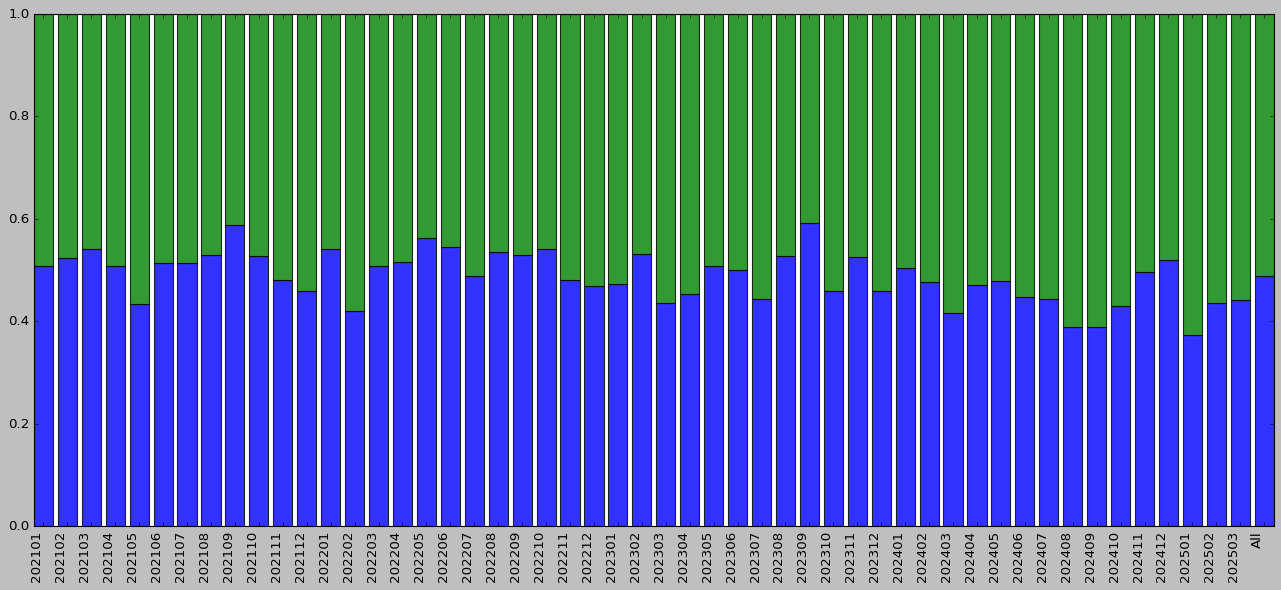

In [65]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,8))

ax.bar(df_temp['MONTH'], df_temp[0], alpha = 0.8)
ax.bar(df_temp['MONTH'], df_temp[1], bottom = df_temp[0], alpha = 0.8)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

In [66]:
df_temp = pd.pivot_table(
    df_4_hour, 
    index = 'WEEK',
    columns = 'FLAG_INCREASE_CANDLE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
).reset_index()

df_temp[0] = df_temp[0]/df_temp['All']
df_temp[1] = df_temp[1]/df_temp['All']

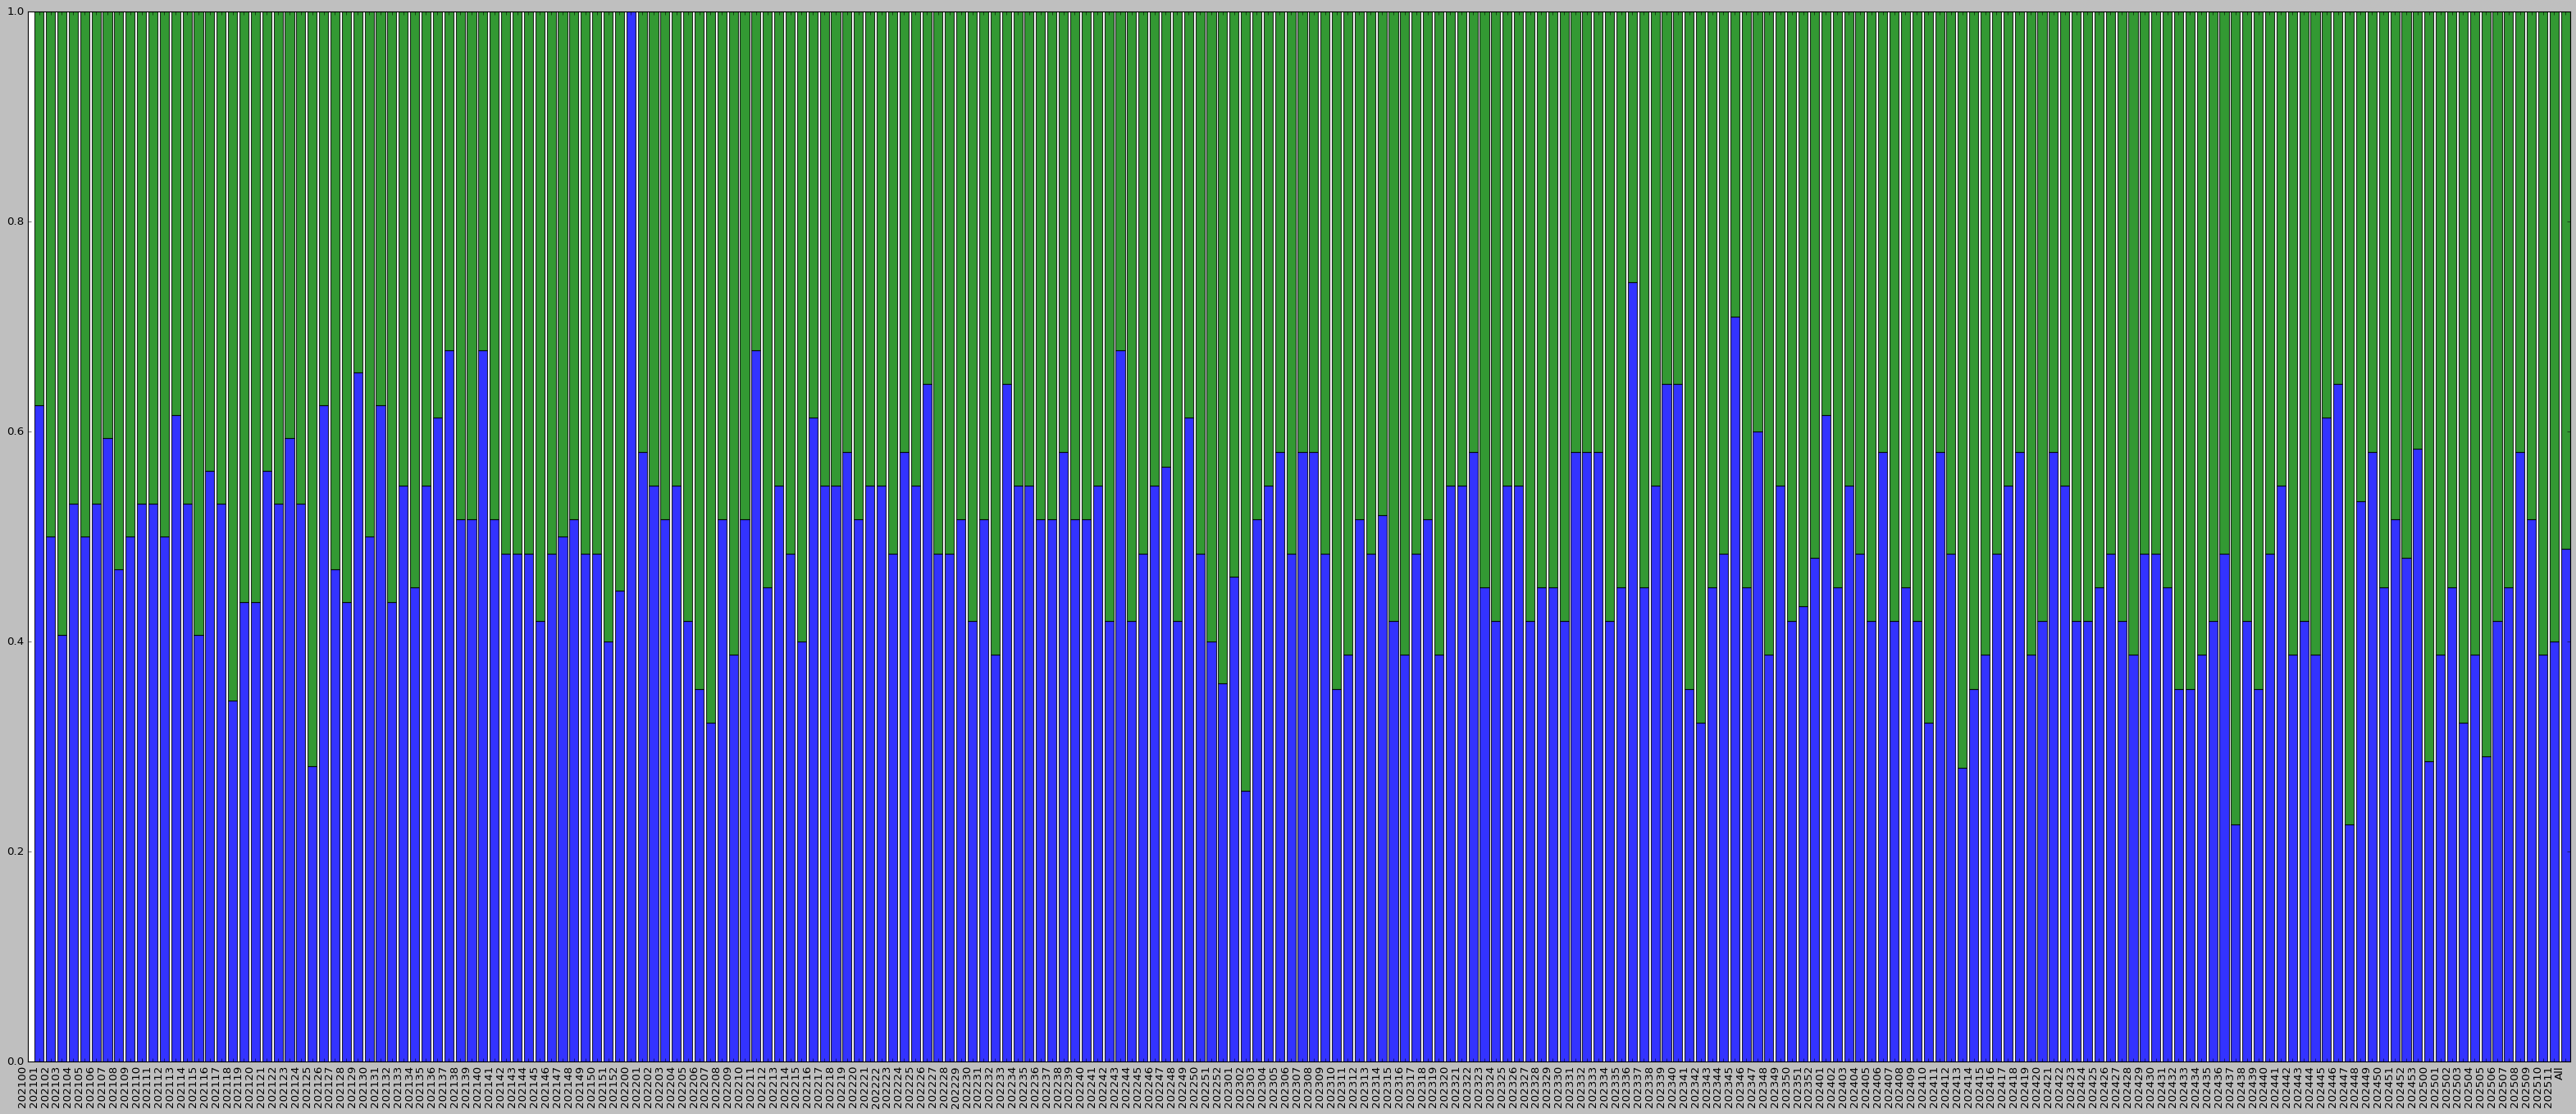

In [69]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (50, 20))

ax.bar(df_temp['WEEK'], df_temp[0], alpha = 0.8)
ax.bar(df_temp['WEEK'], df_temp[1], bottom = df_temp[0], alpha = 0.8)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

### Values of candles

* Same conclustion about the number/ values of candles
* 50% of the candles have body > 3 point, 50% have the whole range > 6, 7 point --> Shadow creation happens almost for most of the candles
* More shifted in late 2024 and 2025 so far ~ 60-70% candles have body > 3 point

For intraday trading, need at least 2 4-hour candle to make a move of 10 point on average; making smaller lots, higher risk resistance, higher reward

#### Body

In [86]:
df_temp = pd.pivot_table(
    df_4_hour, 
    index = ['MONTH'],
    columns = 'GRP_BODY',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)
df_temp.style.background_gradient(axis = 0, cmap='RdYlGn_r')  

GRP_BODY,"(-0.001, 0.485]","(0.485, 1.018]","(1.018, 1.606]","(1.606, 2.285]","(2.285, 3.015]","(3.015, 4.001]","(4.001, 5.202]","(5.202, 7.079]","(7.079, 10.359]","(10.359, 58.402]",All
MONTH,,,,,,,,,,,
202101,0.123077,0.092308,0.061538,0.076923,0.053846,0.107692,0.076923,0.107692,0.161538,0.138462,1.000000
202102,0.054688,0.093750,0.070312,0.101562,0.117188,0.117188,0.156250,0.085938,0.093750,0.109375,1.000000
202103,0.089041,0.095890,0.082192,0.109589,0.116438,0.123288,0.130137,0.061644,0.116438,0.075342,1.000000
202104,0.126866,0.179104,0.134328,0.104478,0.111940,0.044776,0.067164,0.104478,0.089552,0.037313,1.000000
202105,0.095588,0.125000,0.102941,0.125000,0.088235,0.125000,0.132353,0.073529,0.073529,0.058824,1.000000
202106,0.092857,0.128571,0.128571,0.078571,0.128571,0.071429,0.114286,0.050000,0.107143,0.100000,1.000000
202107,0.135714,0.135714,0.107143,0.092857,0.050000,0.078571,0.142857,0.135714,0.092857,0.028571,1.000000
202108,0.164286,0.121429,0.121429,0.150000,0.078571,0.100000,0.057143,0.092857,0.035714,0.078571,1.000000
202109,0.125000,0.102941,0.088235,0.102941,0.102941,0.147059,0.066176,0.139706,0.066176,0.058824,1.000000


In [87]:
df_temp = pd.pivot_table(
    df_4_hour, 
    index = ['WEEK'],
    columns = 'GRP_BODY',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)
df_temp.style.background_gradient(axis = 0, cmap='RdYlGn_r')  

GRP_BODY,"(-0.001, 0.485]","(0.485, 1.018]","(1.018, 1.606]","(1.606, 2.285]","(2.285, 3.015]","(3.015, 4.001]","(4.001, 5.202]","(5.202, 7.079]","(7.079, 10.359]","(10.359, 58.402]",All
WEEK,,,,,,,,,,,
202100,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
202101,0.000000,0.156250,0.062500,0.000000,0.125000,0.031250,0.031250,0.187500,0.281250,0.125000,1.000000
202102,0.125000,0.093750,0.031250,0.062500,0.062500,0.125000,0.156250,0.062500,0.062500,0.218750,1.000000
202103,0.218750,0.062500,0.125000,0.062500,0.031250,0.093750,0.062500,0.125000,0.125000,0.093750,1.000000
202104,0.156250,0.062500,0.031250,0.187500,0.000000,0.125000,0.062500,0.062500,0.187500,0.125000,1.000000
202105,0.062500,0.218750,0.062500,0.093750,0.031250,0.125000,0.187500,0.031250,0.093750,0.093750,1.000000
202106,0.031250,0.031250,0.125000,0.125000,0.031250,0.125000,0.250000,0.062500,0.156250,0.062500,1.000000
202107,0.062500,0.031250,0.031250,0.062500,0.156250,0.156250,0.156250,0.187500,0.062500,0.093750,1.000000
202108,0.062500,0.093750,0.062500,0.125000,0.250000,0.062500,0.031250,0.062500,0.062500,0.187500,1.000000


#### Whole range

In [90]:
df_temp = pd.pivot_table(
    df_4_hour, 
    index = ['MONTH'],
    columns = 'GRP_WHOLE_RANGE',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_temp = df_temp.apply(lambda x: x/x['All'], axis = 1)
df_temp.style.background_gradient(axis = 0, cmap='RdYlGn_r')  

GRP_WHOLE_RANGE,"(0.591, 3.217]","(3.217, 4.408]","(4.408, 5.505]","(5.505, 6.62]","(6.62, 7.815]","(7.815, 9.243]","(9.243, 10.957]","(10.957, 13.518]","(13.518, 18.375]","(18.375, 75.629]",All
MONTH,,,,,,,,,,,
202101,0.023077,0.053846,0.076923,0.084615,0.115385,0.146154,0.123077,0.092308,0.115385,0.169231,1.000000
202102,0.031250,0.039062,0.101562,0.101562,0.109375,0.164062,0.125000,0.109375,0.125000,0.093750,1.000000
202103,0.075342,0.068493,0.068493,0.123288,0.116438,0.116438,0.082192,0.143836,0.136986,0.068493,1.000000
202104,0.186567,0.074627,0.097015,0.141791,0.126866,0.126866,0.067164,0.089552,0.059701,0.029851,1.000000
202105,0.125000,0.139706,0.117647,0.110294,0.117647,0.117647,0.095588,0.044118,0.051471,0.080882,1.000000
202106,0.150000,0.085714,0.114286,0.142857,0.107143,0.078571,0.078571,0.100000,0.057143,0.085714,1.000000
202107,0.185714,0.085714,0.157143,0.071429,0.128571,0.142857,0.050000,0.085714,0.042857,0.050000,1.000000
202108,0.214286,0.128571,0.121429,0.128571,0.100000,0.092857,0.042857,0.028571,0.085714,0.057143,1.000000
202109,0.169118,0.161765,0.117647,0.110294,0.117647,0.066176,0.058824,0.088235,0.051471,0.058824,1.000000
